In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

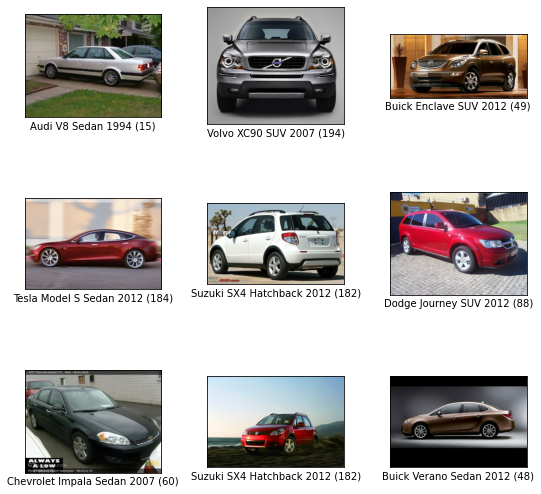

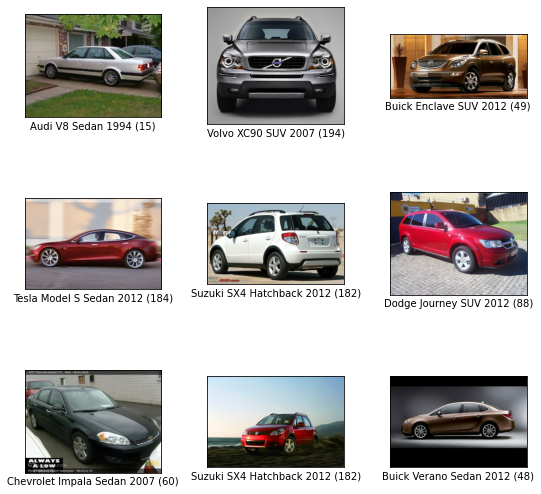

In [4]:
tfds.show_examples(ds_train, ds_info)

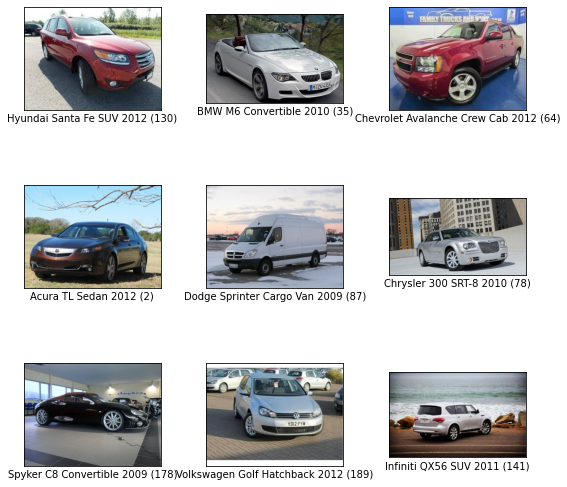

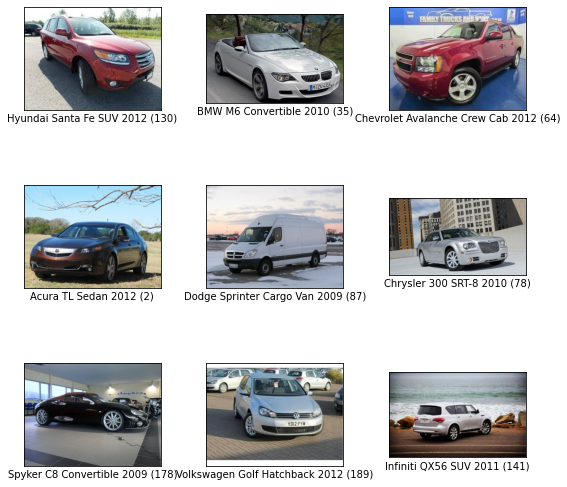

In [5]:
tfds.show_examples(ds_test, ds_info)

## 데이터셋 정보확인

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

## ResNet50모델 불러오기
---
- base_model을 선언하면서 pooling인자에서 'avg'를 주면 마지막에 pooling부분이 GAP로 들어간다?
    - 맞다
    - 설명부분을 보면 "Optional pooling mode for feature extraction when **include_top** is **False**"으로 나와있음
    - pooling인자에 올수 있는 것은 3가지
        1. None
            - 마지막 conv block의 4D tensor의 모양으로 출력이 나갈 것이다
        2. avg
            - 마지막 블럭에서 Global Average Pooling적용하고, 출력의 모양은 2D Tensor로
        3. max
            - Global Max Pooling이 적용된다

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## 데이터 필터링
---
- Bbox에 대한 데이터는 학습에 필요없음
- resize와 정규화진행

In [9]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [11]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
  2/509 [..............................] - ETA: 34s - loss: 5.6576 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0523s vs `on_train_batch_end` time: 0.0839s). Check your callbacks.


509/509 [==============================] - 88s 173ms/step - loss: 4.1811 - accuracy: 0.1585 - val_loss: 5.3982 - val_accuracy: 0.0088
Epoch 2/15
509/509 [==============================] - 78s 153ms/step - loss: 1.6870 - accuracy: 0.6332 - val_loss: 2.1210 - val_accuracy: 0.4559
Epoch 3/15
509/509 [==============================] - 78s 154ms/step - loss: 0.6103 - accuracy: 0.8865 - val_loss: 1.2510 - val_accuracy: 0.6673
Epoch 4/15
509/509 [==============================] - 79s 155ms/step - loss: 0.2037 - accuracy: 0.9756 - val_loss: 1.0901 - val_accuracy: 0.7130
Epoch 5/15
509/509 [==============================] - 79s 155ms/step - loss: 0.0703 - accuracy: 0.9966 - val_loss: 1.0228 - val_accuracy: 0.7231
Epoch 6/15
509/509 [==============================] - 78s 153ms/step - loss: 0.0405 - accuracy: 0.9977 - val_loss: 1.0135 - val_accuracy: 0.7323
Epoch 7/15
509/509 [==============================] - 78s 153ms/step - loss: 0.0268 - accuracy: 0.9983 - val_loss: 0.9977 - val_accuracy: 0.7

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

## CAM

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

141


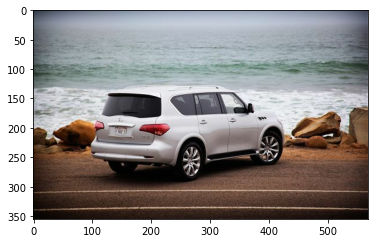

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [16]:
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 만들기 위해서는
1. 특성맵
2. 클래스 별 확률을 얻기위한 소프트맥스 레이어의 가중치
3. 원하는 클래스의 출력값  

3가지가 필요하다.  
또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 **CAM을 입력 이미지 사이즈와 같게** 만들어 함꼐 시각화를 해야할 것이다.  


In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

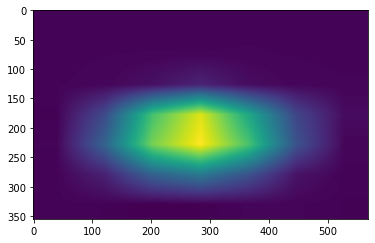

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

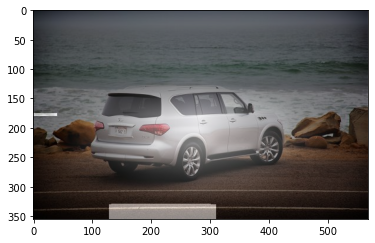

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM

130


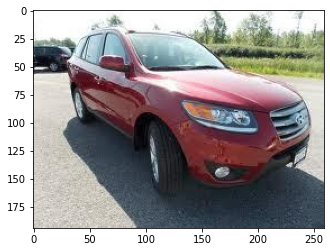

In [21]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [22]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

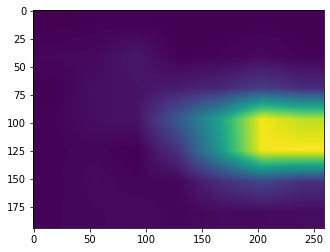

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

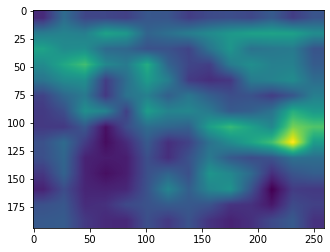

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

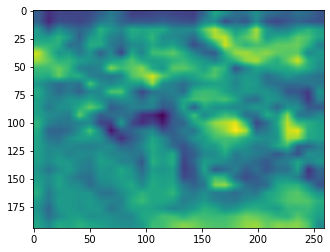

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

## Detection with CAM

13


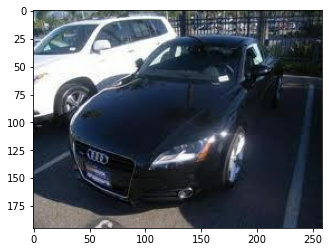

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

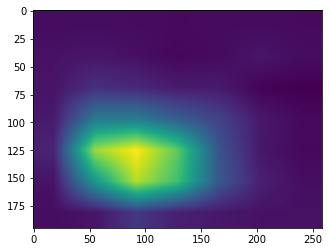

In [27]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [28]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [29]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[209, 194],
       [  0, 194],
       [  0,  49],
       [209,  49]])

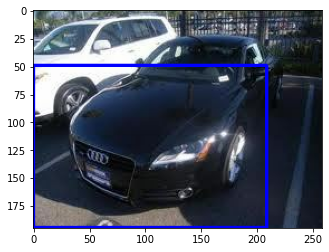

In [30]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

###  IoU

In [31]:

def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), 
        rect[:,0].min()/float(image.shape[1]), 
        rect[:,1].max()/float(image.shape[0]), 
        rect[:,
    ]
    return bbox

In [32]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.2512820512820513, 0.0, 0.9948717948717949, 0.806949806949807]

In [33]:
item['bbox']

array([0.11282051, 0.12355212, 0.8974359 , 0.8880309 ], dtype=float32)

In [34]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [35]:
get_iou(pred_bbox, item['bbox'])

0.5823432716359626

# 정리
---
## 1. CAM(Class Activation Map)
- 일반적인 딥러닝 모델은 모델 안에서 어떤 일이 일어나는지 알수가 없다.
- 일반적인 모델은 Conv층을 거듭하면서 이미지에 대한 feature를 추출하고, classification을 수행할 때는 Fully Connected Layer(Dense Layer)를 지난 후 얻은 Logits을 softmax층을 통과시켜 각 클래스에 대한 확률값을 얻게 된다.
- 여기서 CAM(Class Avtivation Map)의 경우에는 Feature Extraction하는 부분을 똑같이 수행하지만, 이후에 Classification을 수행할때 기존의 Fully Connected Layer를 사용하는 것이 아닌 Global Average Pooling을 사용하게 된다.
- 이러한 GAP(Globak Average Pooling)을 사용하면 기존에 Dense로 층을 구현하는 거에 비해서 입력값의 위치정보가 유지되기 때문에 이후에 나오는 특성맵의 정보를 활용해서 이미지 검출(detection)이나 Segmentation 등의 문제를 푸는데도 활용이 가능해진다.
- 전체적인 흐름을 보자면 GAP를 통과하고 객 채널 별 정보를 요약하고 난 후에, Softmax 층을 지나고 각 클래스에 대한 개별 채널의 중요도를 걸졍하게 된다. 그러고 난 후 각 채널의 가중합을 구하면 각 클래스가 활성화맵에 어떤 부분을 주로 활성화 시키는지 확인할 수 있다.
- 이후에 보간을 통해서 입력이미지의 사이즈와 같게 만들고, 원본 이미지와 겹쳐서 표현을 하면 된다.

#### 참고 코드
```python
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
```
- pretrained model을 가져오면서 ```pooling='avg'``` 옵션을 주게되면 기존에 Feature Extracting하는 부분 이후에 Dense Layer대신에 Global Average Pooling을 적용시키게 된다  
<br>  
<br>  


## 2. ```generate_cam```함수
```python
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]  # 필요없는 맨 앞의 차원을 버린다
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image
```
- ```cam_model``` 변수
    - 입력 : 입력으로 받는 ```model```의 입력 부분의 shape = (224, 224, 3)
    - 출력 
        - ```model```의 뒤에서 3번째 층의 output shape = (7, 7, 2048)
        - 그리고 ```model``` 의 output shape = (None, 196)
            - class의 종류는 196개이고 각 feature에 대한 softmax값을 출력으로 내보내는 층이다.
- ```tf.expand_dims(img_tensor, 0))```??
    - np.newaxis, tf.newaxis와 같이 단순하게 차원을 늘려주는 것
    - 모델에 넣기 위해서 차원을 늘려주는 부분
- ```conv_outputs```, ```predictions```
    - 입력값에 대한 feature map인 conv_outputs, 각 클래스에 대해 softmax값이 담겨있는 precition
- ```class_weights``` 변수
    - 모델의 마지막에 나오는 output의 가중치들을 가져온다
    - ```model.layers[-1].get_weights()```는 리스트를 return하고.. 길이는 2
        - ```model.layers[-1].get_weights()[0]```의 shape의 경우, (2048, 196) = image
        - ```model.layers[-1].get_weights()[1]```의 shape의 경우, (196,) = label
        - 각각은 뭘까..... 일단 떠오르는 것은 image와 label이 떠오르긴하는데...
- 반복문 부분
    - 앞서 나왔던 가중합부분을 구현하였다.
    - ```conv_outputs[:, class_idx]```로 for문을 돌리면... ```conv_output.shape=(2048, 196)```이기 때문에 2048번을 반복문을 돌린다.
        - 이떄 등장하는 ```class_idx``` : 위에서 item에 대해서 scaling을 수행하면서 사진에 대한 class를 저장해 놓은 것
    - 2048번을 돌리면서... 각 가중치를 conv_output에 곱해주는데, 이때 conv_output은 7x7의 feature map이 2048개의 채널이 있음.. **각 채널에 대한 가중치를 채널의 feature map에 곱해주는 부분**
        - 위에서 ```class_idx```를 13으로 주었다면 13번 클래스에 대한 값들에 대해 연산이 수행
    - 그럼 이러한 가중치의 값들이 담기게 되는 cam_image은 수식에서 $S_c$(클래스에 대한 score), $M_c(x,y)$(모델이 class에 대해 각 위치를 얼마나 보는지)와 같은 의미
- 이후 부분...
    - cam_image 정규화
    - EagerTensor -> numpy.ndarray()
    - resize 수행  
<br>  
<br>  

## 3. ```generate_grad_cam```함수
---
```python
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image
```
---
- 앞 부분의 코드는 기존의 코드와 같다
- ```model.get_layer('layer_name')```로 특정 원하는 layer에 대해서 접근 가능
- with 문 [참고](https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221653260516&proxyReferer=https:%2F%2Fwww.google.com%2F)
    - Gradient를 얻어야 한다... tf.GradientTape() [사용법](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
    - conv_output과 pred는 동일.. 하지만 여기서 원하는 layer로 입력을 받는 층에 따라서 conv_outputs의 shape이 달라짐
    - 사진의 해당 클래스에 얼마나 속하는지 loss에 담고.. conv_outputs 담는 것도 이전과 동일
    - gradient를 구한다...  이때 grad_val의 shape는 [14, 14, 1024] (conv_outputs와 동일한 shape)
- weights에 들어가는 값은... grad_val을 평균낸 값인데 *axis를 (0, 1)로 주었기 때문에* **각 채널별로 평균값들이 생성된다 = GAP(Global Average Pooling)와 동일한 연산**
- 이후에 이 weights를 돌면서 output의 각 채널과 가중합을 grad_cam_image에 계산
- 그 뒤 연산도 이전과 동일